# No Limit Texas Hold'em Deep Q learning

This notebook is using modern deep learning libraries to try to solve No Limit Hold'em (NLH). There are AIs developed that have beaten world class players in heads-up (2 players) NLH. We still have a long way to go here.

To run the notebook you need to install the https://github.com/VinQbator/holdem fork of the holdem library. A lot of bugfixes and changes were needed to effectively run the environment for deep learning.

Fast Monte Carlo simulations library for equity based rewards can be installed from https://github.com/mitpokerbots/pbots_calc. ( Make sure to add the library to LD_LIBRARY_PATH, which is not said in the instructions)

Also keras-rl should be installed from https://github.com/VinQbator/keras-rl. Sorry for the inconvenience.

Rest of the libraries are found from pip as listed in the following imports section.

A lot of heavy lifting is in .py files adjacent to the notebook to keep the notebook clean.

Most of the effort here is put into building a convenient framework to play around in. As it is quite a challenge to get serious results out from, it is considered more of a learning experience than serious attempt to create a world class bot.

There is still a lot of stuff to try out here: 
* feature engineering pot odds, outs for draws
* trying out different model architectures, hyperparameters, optimizers

I encourage everyone to experiment and I'm hoping to hear about your results :)

# Imports

In [1]:
from players.atm import ATM
from players.ai_player import AIPlayer
from players.random_player import RandomPlayer
from training_env import TrainingEnv
from agents import build_dqn_agent, fit_agent, train_loop, load_agent_weights
from models import simple_model, complex_model, test_model
from util import visualize_history, use_jupyter, set_on_demand_memory_allocation
from helpers.poker_history import PokerHistory

Using TensorFlow backend.


In [2]:
from keras.optimizers import Adam
from rl.memory import SequentialMemory

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
set_on_demand_memory_allocation()

In [5]:
use_jupyter()

# Feature Engineering

### Some of the stuff that is happening in the wrapper layer for the holdem gym environment.
* Positions are one-hot encoded
* Pot and bet sizes are normalized to 100 big blinds
* Hand ranking either normalized or one-hot encoded
* Cards are one-hot encoded

# Action space

### Essentially infinite or at least large action space is split up into

* Base moves like FOLD/CALL/CHECK

* And few common bet/raise sizes relative to the pot size: 1/5, 1/4, 1/3, 2/5, 1/2, 3/5, 2/3, 3/4, 4/5, 1, 4/3, 5/3, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100

In [6]:
# How many players in table
NUMBER_OF_SEATS = 2
# Max betsize in simulation environment (shouldn't really matter with discrete relative to pot sizing)
MAX_BET = 100000
# 'norm' (normalized) or 'one-hot' < how to encode player hand ranking from 7642 unique values
RANK_ENCODING = 'norm'

WINDOW = 1
MODEL = complex_model

FIRST_RUN_STEPS = 1000000
SECOND_RUN_STEPS = 500000
THIRD_RUN_STEPS = 500000
THIRD_RUN_ITERATIONS = 10

BENCHMARK_EPISODES = 100000

In [7]:
# Lets start with playing against player that always calls or checks based on which is currently valid move
# Hopefully this will teach the agent something about hand strength at least
env = TrainingEnv.build_environment(ATM(), NUMBER_OF_SEATS, debug=False)

### First lets train against an opponent who always calls or folds based on whichever move is valid

In [8]:
model = MODEL(WINDOW, env.n_observation_dimensions, env.n_actions)
print(model.summary())
# window_length - how many timesteps to look into past (will multiply observation space by this, be careful)
# enable_double_dqn - https://arxiv.org/pdf/1509.06461.pdf
# enable_dueling_network - ???
# train_interval - every how many steps to run a train cycle (or if in 0...1 range, the soft update weight)
# n_warmup_steps - how many steps to run without training
# batch_size - number of (s, a, G) triplets to train on in one training cycle (as a batch)
# gamma - future reward discount essentially
# memory_interval - how often to add last step to memory buffer (discarding every other)

memory = SequentialMemory(limit=2048, window_length=WINDOW)
optimizer = Adam(lr=0.001, beta_1=.99, beta_2=.9999, epsilon=None, 
                     decay=0.0, amsgrad=True)

agent = build_dqn_agent(model, env.n_actions, memory=memory, optimizer=optimizer, window_length=WINDOW,
                        target_model_update=0.001, enable_double_dqn=True, enable_dueling_network=True, 
                        dueling_type='avg', train_interval=256, n_warmup_steps=256, batch_size=256, 
                        gamma=.99, memory_interval=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 390)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1601536   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
__________

In [9]:
# Let's play for 100000 steps (decisions made by AI)
agent, hist = fit_agent(agent, env, FIRST_RUN_STEPS, debug=False) 

Could not load previous weights
Training for 1000000 steps ...
Interval 1 (0 steps performed)
200000/200000 [==============================] - 1077s 5ms/step - reward: 0.3564
70682 episodes - episode_reward: 1.009 [-79.600, 81.000] - loss: 294.850 - mean_absolute_error: 0.743 - mean_q: 0.769 - money_won: 2.726 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.001 - outer_duration: 0.003

Interval 2 (200000 steps performed)
200000/200000 [==============================] - 1078s 5ms/step - reward: 0.3568
72100 episodes - episode_reward: 0.990 [-79.600, 81.000] - loss: 293.209 - mean_absolute_error: 0.899 - mean_q: 1.016 - money_won: 2.610 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.001 - outer_duration: 0.003

Interval 3 (400000 steps performed)
200000/200000 [==============================] - 1141s 6ms/step - reward: 1.5450
87587 episodes - episode_reward: 3.528 [-79.600, 81.000] - loss: 207.686 - mean_absolute_error: 1.852 - mean_q: 2.792 - mon

## As we can see the simple network was able to learn a bit and achieve a positive winrate

Total $ won: 21649764
Winrate BB/100: 214.5171107747719
Total hands: 403693


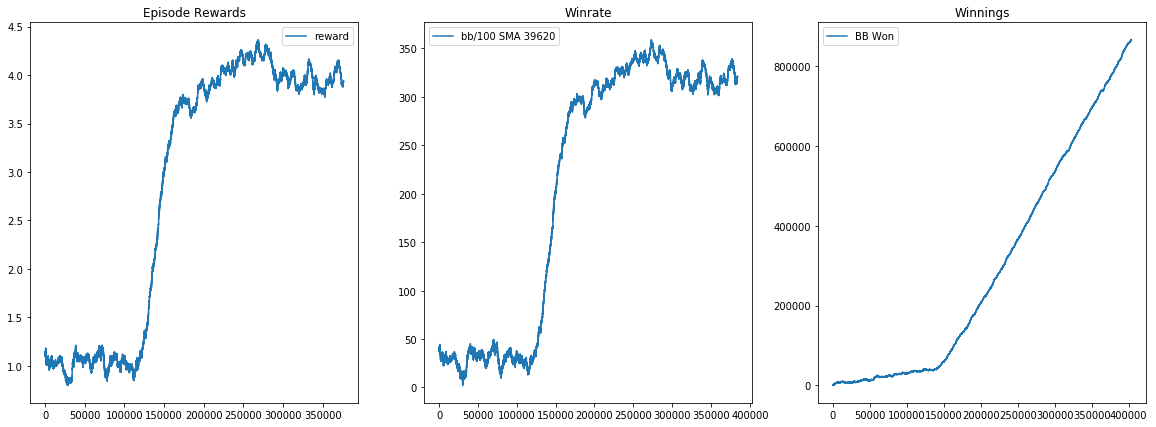

In [10]:
# Some plots of how the training session went
visualize_history(hist)

### Hand history rendering is still a bit wonky, but it's clear that the bot is not making too smart choices

Perfect strategy here would be to check/call until river and then shove ~top50% of hands (a bit more considering there is already some money in pot)

In [11]:
# Let's evaluate our agent for 5 episodes (hands).
agent.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [K♠],[6♥] stack: 2400
0 SB [J♠],[2♠] stack: 1600
Episode 1: reward: -15.000, steps: 1
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [Q♥],[9♣] stack: 1680
1 SB [2♥],[K♥] stack: 2320
Episode 2: reward: -12.400, steps: 1
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [9♠],[5♥] stack: 1440
0 SB [K♥],[3♠] stack: 2560
Episode 3: reward: 23.400, steps: 1
total pot: 0
last action by player 0:
x fold
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 SB [8♠],[J♣] stack: 1975
0 BB [6♣],[2♣] stack: 1990
Episode 4: reward: 0.000, steps: 1
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [A♣],[3♣] stack: 2280
0 SB [5♠],[T♣] stack: 1720
Episode 5: reward

# Lets now play against opponent who makes totally random moves

In [12]:
# Lets play against our bot with totally random moves now
# Hopefully it teaches the agent at least something about how to act on wide range of situations
env = TrainingEnv.build_environment(RandomPlayer(), NUMBER_OF_SEATS, debug=False)

In [13]:
# Train for playing against RandomPlayer
agent, hist = fit_agent(agent, env, SECOND_RUN_STEPS, False, hist)

Could not load previous weights
Training for 500000 steps ...
Interval 1 (0 steps performed)
100000/100000 [==============================] - 581s 6ms/step - reward: 0.4563
49867 episodes - episode_reward: 0.915 [-79.600, 81.000] - loss: 174.418 - mean_absolute_error: 1.551 - mean_q: 2.340 - money_won: 2.680 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.001 - outer_duration: 0.003

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 569s 6ms/step - reward: 0.5794
44245 episodes - episode_reward: 1.310 [-79.600, 81.000] - loss: 150.009 - mean_absolute_error: 1.616 - mean_q: 1.958 - money_won: 6.743 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.001 - outer_duration: 0.003

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 553s 6ms/step - reward: 0.7384
43402 episodes - episode_reward: 1.701 [-79.600, 81.000] - loss: 144.867 - mean_absolute_error: 1.739 - mean_q: 2.043 - money_w

# Our winrate is positive even if the opponent is not totally predictable

Total $ won: 26037797
Winrate BB/100: 166.4874004923431
Total hands: 625580


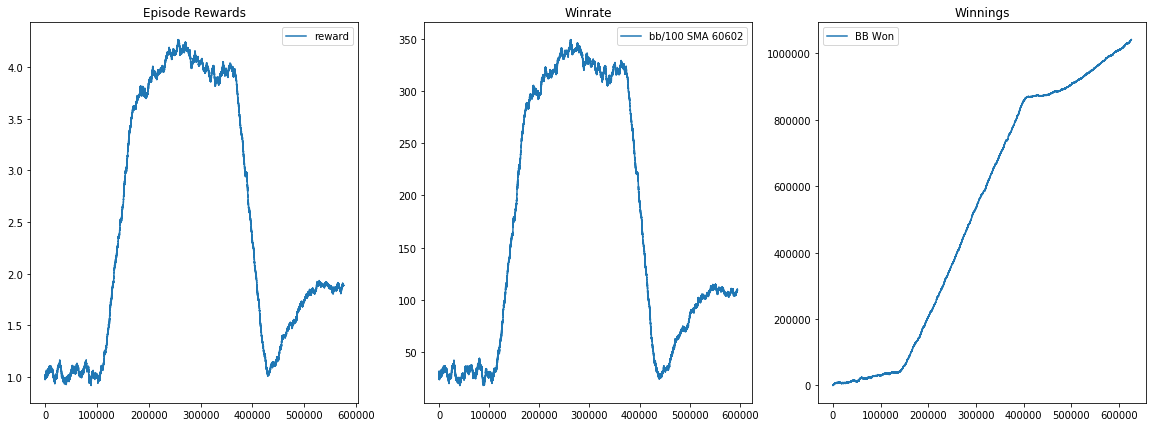

In [14]:
visualize_history(hist)

# Hand history shows that AI is still making quite random moves

Ideally we should play quite tightly and passively here and waiting for strong hands cheaply (22/25 random moves that opponent can make are aggressive)

In [15]:
agent.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [K♦],[T♦] stack: 1700
1 SB [3♥],[3♣] stack: 2300
Episode 1: reward: -11.600, steps: 1
total pot: 0
last action by player 1:
x fold
community:
- [3♠],[K♥],[J♣],[  ],[  ] 
players:
0 SB [K♠],[2♠] stack: 2050
1 BB [Q♥],[5♣] stack: 1950
Episode 2: reward: 3.000, steps: 1
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [J♦],[2♠] stack: 1620
1 SB [5♥],[K♦] stack: 2380
Episode 3: reward: -14.800, steps: 1
total pot: 0
last action by player 1:
x fold
community:
- [A♥],[7♠],[2♠],[  ],[  ] 
players:
0 SB [6♣],[4♦] stack: 2050
1 BB [7♥],[T♠] stack: 1950
Episode 4: reward: 3.000, steps: 1
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [6♦],[2♠] stack: 1880
1 SB [3♦],[6♥] stack: 2120
Episode 5: reward: -4.400, steps: 1


### Now let's play iterations against the previous version of ourselves

Continously finding leaks in our strategy and start exploiting these will hopefully converge somewhere near nash equilibrium. Or it might blow up... go find out!

In [16]:
agent, hist = train_loop(agent, MODEL, env, steps_in_iteration=THIRD_RUN_STEPS, 
                         n_iterations=THIRD_RUN_ITERATIONS, window_length=WINDOW, verbose=1, debug=False)

ITERATION 0
7244 objects released from memory
Training for 500000 steps ...
Interval 1 (0 steps performed)
100000/100000 [==============================] - 939s 9ms/step - reward: 0.2767
69837 episodes - episode_reward: 0.396 [-75.200, 78.800] - loss: 565.345 - mean_absolute_error: 18.049 - mean_q: 24.484 - money_won: -5.304 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.002 - outer_duration: 0.003

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 947s 9ms/step - reward: 0.2805
69853 episodes - episode_reward: 0.402 [-76.600, 77.000] - loss: 388.427 - mean_absolute_error: 11.747 - mean_q: 21.281 - money_won: -5.211 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.002 - outer_duration: 0.003

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 947s 9ms/step - reward: 0.3007
69953 episodes - episode_reward: 0.430 [-76.400, 77.000] - loss: 334.332 - mean_absolute_error: 9.499 - mea

100000/100000 [==============================] - 930s 9ms/step - reward: -0.1102
done, took 4642.341 seconds
Total $ won: -21260675
Winrate BB/100: -72.36900553642758
Total hands: 1175126
ITERATION 5
0 objects released from memory
Training for 500000 steps ...
Interval 1 (0 steps performed)
100000/100000 [==============================] - 911s 9ms/step - reward: -0.3902
38246 episodes - episode_reward: -1.020 [-79.400, 81.000] - loss: 271.127 - mean_absolute_error: 7.647 - mean_q: 11.733 - money_won: -16.448 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.003 - outer_duration: 0.004

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 914s 9ms/step - reward: -0.0825
38435 episodes - episode_reward: -0.215 [-79.200, 81.000] - loss: 209.685 - mean_absolute_error: 6.025 - mean_q: 9.246 - money_won: -8.790 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.003 - outer_duration: 0.004

Interval 3 (200000 steps performed)


100000/100000 [==============================] - 891s 9ms/step - reward: -0.2540
43612 episodes - episode_reward: -0.582 [-79.200, 80.200] - loss: 187.969 - mean_absolute_error: 4.863 - mean_q: 8.234 - money_won: -13.982 - inner_duration: 0.000 - encode_duration: 0.000 - step_duration: 0.003 - outer_duration: 0.003

Interval 5 (400000 steps performed)
100000/100000 [==============================] - 884s 9ms/step - reward: -0.1134
done, took 4464.954 seconds
Total $ won: -53006921
Winrate BB/100: -94.52815166755758
Total hands: 2243011
0 objects released from memory


#### Be careful when visualizing very long hand histories. SMA calculation will take a long time.

Here the winrates really don't show us much, since we are competing against ourself.

Total $ won: -53006921
Winrate BB/100: -94.52815166755758
Total hands: 2243011


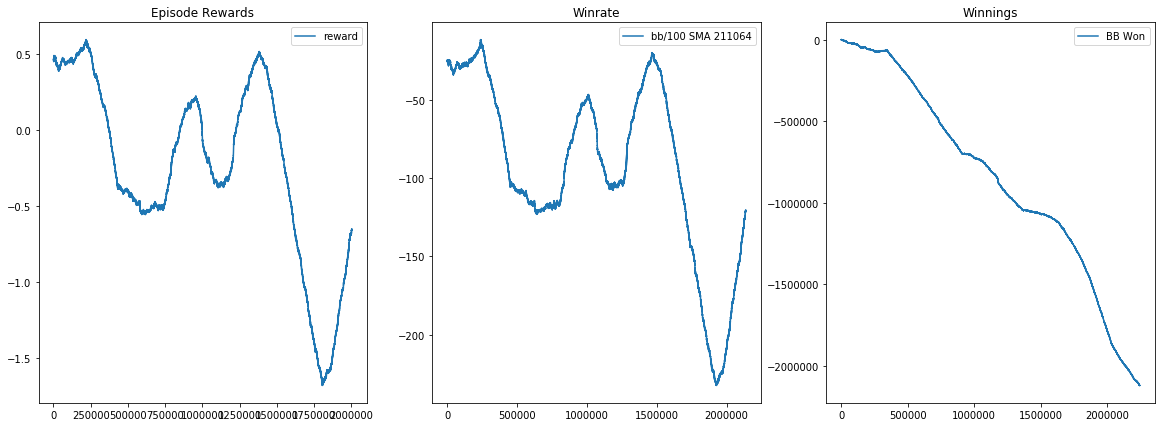

In [17]:
visualize_history(hist)

### Strategy still seems quite primitive and very far off solid poker

In [18]:
agent.test(env, nb_episodes=50, visualize=True)

Testing for 50 episodes ...
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [7♥],[J♣] stack: 2560
0 SB [5♦],[T♣] stack: 1440
Episode 1: reward: -21.400, steps: 1
total pot: 3500
last action by player 1:
- call, current bet: 0
community:
- [5♠],[K♣],[9♦],[  ],[  ] 
players:
0 BB [K♥],[4♥] stack: 250
1 SB [4♠],[6♣] stack: 250
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [5♠],[K♣],[9♦],[  ],[  ] 
players:
0 BB [K♥],[4♥] stack: 2540
1 SB [4♠],[6♣] stack: 1460
Episode 2: reward: 22.000, steps: 2
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [A♣],[9♥] stack: 2400
0 SB [Q♥],[3♦] stack: 1600
Episode 3: reward: -15.000, steps: 1
total pot: 3500
last action by player 1:
- call, current bet: 0
community:
- [J♣],[3♠],[9♦],[  ],[  ] 
players:
0 BB [6♣],[K♦] stack: 250
1 SB [3♥],[T♥] stack: 250
total pot: 4000
last action by playe

total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [K♣],[4♣] stack: 2200
0 SB [7♦],[6♣] stack: 1800
Episode 29: reward: -7.000, steps: 1
total pot: 3500
last action by player 1:
- call, current bet: 0
community:
- [3♦],[T♥],[5♣],[  ],[  ] 
players:
0 BB [5♠],[K♣] stack: 250
1 SB [A♠],[A♥] stack: 250
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [3♦],[T♥],[5♣],[  ],[  ] 
players:
0 BB [5♠],[K♣] stack: 820
1 SB [A♠],[A♥] stack: 3180
Episode 30: reward: -46.800, steps: 2
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
1 BB [T♠],[2♥] stack: 1360
0 SB [K♠],[8♠] stack: 2640
Episode 31: reward: 26.600, steps: 1
total pot: 3500
last action by player 1:
- call, current bet: 0
community:
- [3♠],[Q♥],[3♥],[  ],[  ] 
players:
0 BB [5♥],[2♥] stack: 250
1 SB [A♥],[6♥] stack: 250
total pot: 4000
last action by player 1:
- call, current bet: 0

In [19]:
load_agent_weights(agent)

## Playing again vs hardcoded opponents shows there probably is a bit of improvement

Total $ won: 1064802
Winrate BB/100: 42.92215134383408
Total hands: 99231


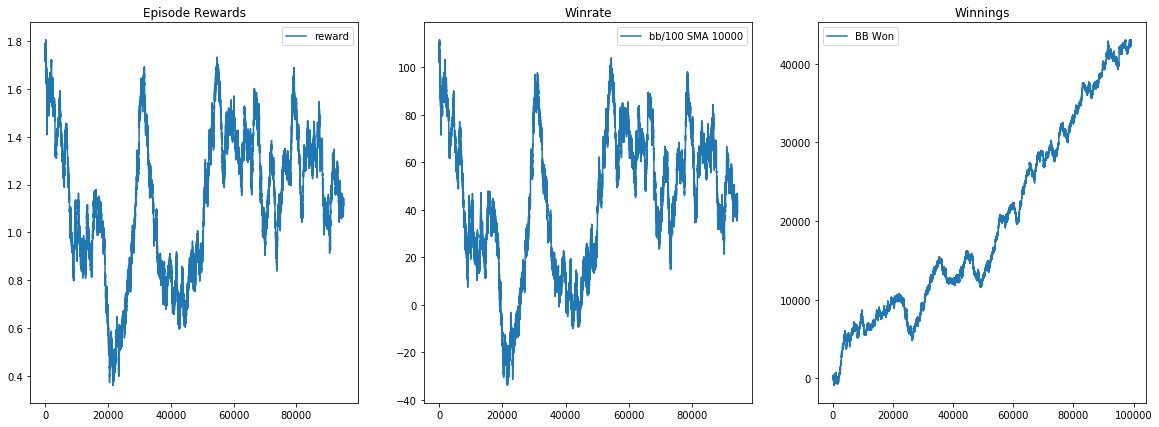

In [20]:
# Let's benchmark against ATM
env = TrainingEnv.build_environment(ATM(), n_seats=NUMBER_OF_SEATS)
hist = agent.test(env, nb_episodes=BENCHMARK_EPISODES, visualize=False, verbose=0, history=PokerHistory())
visualize_history(hist)

Total $ won: 5677902
Winrate BB/100: 228.69867482982238
Total hands: 99308


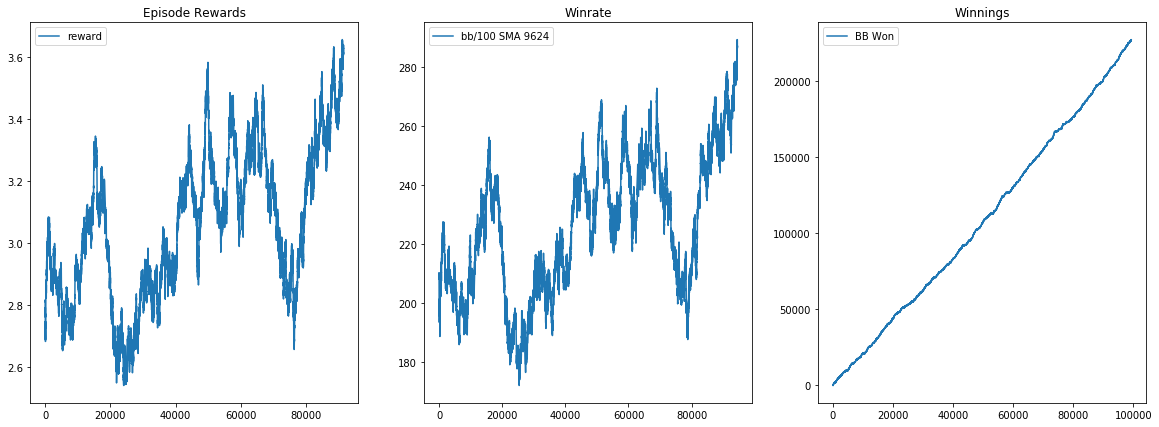

In [21]:
# Let's benchmark against RandomPlayer
env = TrainingEnv.build_environment(RandomPlayer(), n_seats=NUMBER_OF_SEATS)
hist = agent.test(env, nb_episodes=BENCHMARK_EPISODES, visualize=False, verbose=0, history=PokerHistory())
visualize_history(hist)